In [17]:
import sys
import os
import time
import numpy as np
import math
import msgpack
import torch

from typing import Any, Tuple, List, Dict, Optional, Union

# pyngp_path = '/cluster/home/jpostels/nnaimi/instant-ngp/build'
# sys.path.append(pyngp_path)
# import pyngp as ngp

sys.path.append(os.path.abspath("/Users/nasib/code/instant-ngp/scripts"))
from scenes import *
from utils import *
# from quantizers import *

import numpy as np
import matplotlib.pyplot as plt

In [18]:
from typing import Any, Tuple


# Implement uniform, asymmetric, uint8 bit quantization
def quantization_uniform_asymmetric(x: np.ndarray, bits: int = 8) -> Tuple[Any]:
    """Uniformly quantizes x to bits number of bits in asymmetric mode.
    Args:
        x: Input array.
        bits: Number of bits to quantize to.
    Returns:
        x_q: Quantized array.
        q_x: Quantization factor.
        zpx: Zero-point.
    """
    MAX_NUM = 2.0**bits - 1.0  # highest representable binary number
    x_min, x_max = x.min(), x.max()
    q_x = MAX_NUM / (x_max - x_min)
    zpx = np.round(x_min * q_x)
    x_q = np.round(q_x * x - zpx)
    return x_q, q_x, zpx


def dequantize_uniform_asymmetric(
    x_q: np.ndarray, q_x: np.ndarray, zpx: np.ndarray
) -> np.ndarray:
    """Dequantizes x_q to float32.
    Args:
        x_q: Quantized array.
        q_x: Quantization factor.
        zpx: Zero-point.
    Returns:
        x: Dequantized array.
    """
    return (x_q + zpx) / q_x

In [19]:
snapshot_path = "/Users/nasib/code/instant-ngp/data/kodim11-20230721-232433.ingp"
# snapshot_path = '/Users/nasib/code/sandbox/kodim11.ingp'

In [20]:
snapshot = deserialize_ingp(snapshot_path)
cp_snapshot = copy.deepcopy(snapshot)
config = snapshot['snapshot']


In [21]:
# info on the snapshot
mode = config["mode"]
bg_color = config["background_color"]
camera = config["camera"]
n_params = config["n_params"]
precision = config["params_type"]
params_b = config["params_binary"]

print("Mode: ", mode, "\tNumber of Params: ", n_params, "\tParams Precision: ", precision)
print("Params Binary: ", params_b)

Mode:  image 	Number of Params:  214080 	Params Precision:  __half
Params Binary:  b'B\xaf\x0f*U\xac\xb8,\x1f\xaa\x18%\xd5%\x81\xa9*\xa2\xa6(\xa3\xacw)\x0b.\x82(_-\xaf((-\x96\x11\x1a\x9fE\xacr\xa0\xae\xac\xd6\xa5\xb2">*\xa2\xa6 \xa5\xa7&,\x80\x05\x80\x1e\x00\x04\x80\x1b\xaf\xb2/\x0f\xac\xd2(,)I\xa0\xb5\xac!1\x18\'\xee\xaa^-\x8f\x9d\xe4"\xa7\xb0o\x95t\xb0\xfd+\xbd*d\xa9U%K(j\xac\xef\xaa\x03\xac\xc5\xa3\t\xa9\x88\x9cB \x00\x00\x00\x80\x00\x00\x00\x80\x0b\xb2&0\x11\xa9\xe2\xa5\x7f.U\x1e\xc2,e,K\xb0L\x11\xff*\x89\xad?+\x9d\xa8C"\xf0)d\xac\xb9\xa6\x88\xad>#%*\x8c,%\xa9\xed"\xef\xa8\x00.\x87\xad\xcf-\x16\x00\x00\x00\x07\x80\x11\x00\xfc\'\xba)\x941t\xaf\x97-\xf5*\x00(Q0z\x9c1\x9f\xcd.\x08\x1f )\x87\xa0\x8d)J\xb1\x9b\x85+.#\xadx \xec,\xfc\xa0i\x9d\x18\xae\xb9\xab\xdb-\xf2\xa0\xd6*\x03\x80\x11\x00\x00\x00\x00\x80](\x8f\xb4\x81\xb3\x04\xad\x0c\xb0\t4=\xb0\x88\x18;\xb0N\x9fH\xad\x12\xb1\xde4\xd2/82\r\xae>%m\xa5\xe5\xb0\x07\xb4}\xa6(\xad\x06\xacR\xaf\xb7\xb2\x1e2[\xac\xa0#$\x80\x02\x80\x00\x80\x00

In [22]:
# loading of binary params -> deserialization, assumes __half precision
if precision in ['float', '__half']:
    np_dtype = np.float32 if precision == 'float' else np.float16
    params_array = np.frombuffer(config["params_binary"], dtype=np_dtype)
    n_params = len(params_array)
    params_np_half = np.array(params_array, dtype=np.float16)
    params_np_fp = np.array(params_array, dtype=np.float32)
    # params_half = torch.tensor(params_array, dtype=torch.float16)
    # params_fp = torch.tensor(params_array, dtype=torch.float32)
else:
    raise RuntimeError("Trainer: snapshot parameters must be of type float or __half")


In [24]:
print(
    "Deserialized binary params\t",
    params_array,
    "min: ",
    params_array.max(),
    "max: ",
    params_array.min(),
    "type: ",
    type(params_array),
    "dtype: ",
    params_array.dtype,
)
print(
    "numpy tensor half precision\t",
    params_np_half,
    "min: ",
    params_np_half.max(),
    "max: ",
    params_np_half.min(),
    "type: ",
    type(params_np_half),
    "dtype: ",
    params_np_half.dtype,
)
print(
    "numpy tensor full precision\t",
    params_np_fp,
    "min: ",
    params_np_fp.max(),
    "max: ",
    params_np_fp.min(),
    "type: ",
    type(params_np_fp),
    "dtype: ",
    params_np_fp.dtype,
)

mse_between_precisions = np.mean(
    np.power(params_np_half.astype(np.float32) - params_np_fp, 2)
)
print(
    mse_between_precisions, type(mse_between_precisions), mse_between_precisions.dtype
)
print(
    "Are the two arrays equal? ", np.allclose(params_np_half, params_np_fp, atol=1e-10)
)

Deserialized binary params	 [-0.1134   0.04733 -0.0677  ...  0.4365  -0.2428   0.2262 ] min:  3.297 max:  -3.072 type:  <class 'numpy.ndarray'> dtype:  float16
numpy tensor half precision	 [-0.1134   0.04733 -0.0677  ...  0.4365  -0.2428   0.2262 ] min:  3.297 max:  -3.072 type:  <class 'numpy.ndarray'> dtype:  float16
numpy tensor full precision	 [-0.11340332  0.04733276 -0.06768799 ...  0.43652344 -0.24279785
  0.22619629] min:  3.296875 max:  -3.0722656 type:  <class 'numpy.ndarray'> dtype:  float32
0.0 <class 'numpy.float32'> float32
Are the two arrays equal?  True


In [26]:
# nr. of bits to quantize to
bits = 8

In [27]:
# quantize and dequantize
p_q, q_x, zpx = quantization_uniform_asymmetric(params_np_fp, bits=bits)
p_dq = dequantize_uniform_asymmetric(p_q, q_x, zpx)
error = np.abs(params_np_fp - p_dq)

print("quantized statistics (min, max, std, mean, median):\t", *statistics_of_params(p_q))
print("dequantized statistics (min, max, std, mean, median):\t", *statistics_of_params(p_dq))
print("statistics (min, max, std, mean, median):\t\t", *statistics_of_params(params_np_fp))
print("error statistics (min, max, std, mean, median):\t\t", *statistics_of_params(error))
print("MSE:\t\t\t\t\t\t\t", np.mean(np.power(error, 2)))

quantized statistics (min, max, std, mean, median):	 -0.0 255.0 11.804702 122.96588 123.0
dequantized statistics (min, max, std, mean, median):	 -3.0721736 3.2969668 0.29484627 -0.00085205154 0.0
statistics (min, max, std, mean, median):		 -3.0722656 3.296875 0.29473543 -0.00084116944 0.0
error statistics (min, max, std, mean, median):		 0.0 0.012488484 0.0036311292 0.0062025064 0.006205477
MSE:							 5.165619e-05


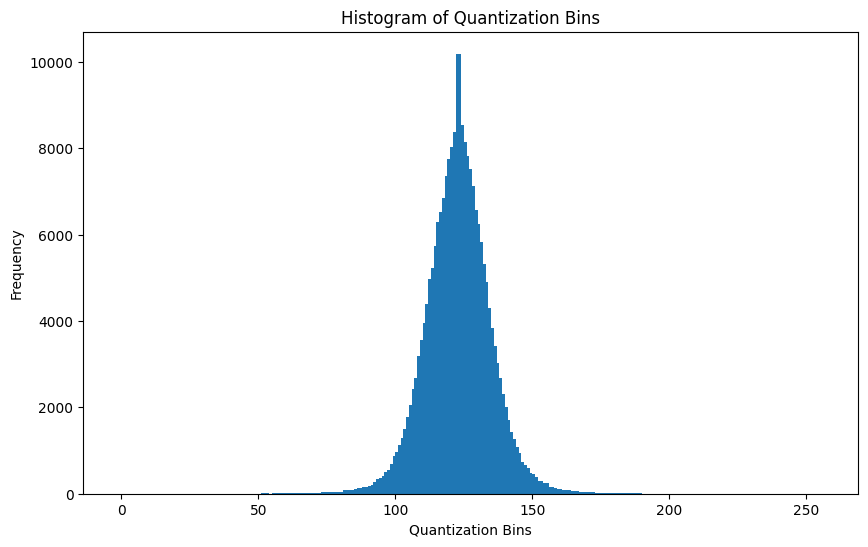

In [28]:
plot_quantization_bins(p_q, n_bins=2**bits)

In [32]:
# full precision (float32)
fp_quant = quantization_uniform_asymmetric(params_np_fp, bits=bits)
full_dq = dequantize_uniform_asymmetric(*fp_quant)
fp_error = np.abs(params_np_half - full_dq)
fp_mse = np.mean(fp_error**2)

# half precision (float16)
half_quant = quantization_uniform_asymmetric(params_np_half, bits=bits)
half_dq = dequantize_uniform_asymmetric(*half_quant)
half_error = np.abs(params_np_half - half_dq)
half_mse = np.mean(half_error**2)

print(
    "difference in quantization using full precision or half?",
    (fp_quant[0] - half_quant[0]).any(),
)

print(
    "full error statistics (min, max, std, mean, median, mse):",
    *statistics_of_params(fp_error),
    fp_mse
)
print(
    "half error statistics (min, max, std, mean, median, mse):",
    *statistics_of_params(half_error),
    half_mse
)

difference in quantization using full precision or half? True
full error statistics (min, max, std, mean, median, mse): 0.0 0.012488484 0.0036311292 0.0062025064 0.006205477 5.165619e-05
half error statistics (min, max, std, mean, median, mse): 0.0 0.01563 0.003727 0.006252 0.006226 5.3e-05


In [35]:
# examining whether quantization and dequantization of already quantized params yields the same result
dq_quant = quantization_uniform_asymmetric(half_dq, bits=bits)
quant_dq = dequantize_uniform_asymmetric(*dq_quant)

error = quant_dq - half_dq
print(f"Quantization error -> max-diff: {error.min()} - {error.max()}, mean: {error.mean()}, any none-zero diff? {error.any()}")

Quantization error -> max-diff: 0.0 - 0.0, mean: 0.0, any none-zero diff? False


In [36]:
# Perform quantization and dequantization on the snapshot which is stored in half precision
half_quant = quantization_uniform_asymmetric(params_np_half, bits=bits)
half_dq = dequantize_uniform_asymmetric(*half_quant)

# store the dequantized params in the snapshot fp16
print("Binary params before quantization: ", cp_snapshot['snapshot']['params_binary'])
print("# Bytes: ", sys.getsizeof(cp_snapshot['snapshot']['params_binary']), type(cp_snapshot['snapshot']['params_binary']))
cp_snapshot['snapshot']['params_binary'] = half_dq.tobytes()
print("Binary params after quantization: ", cp_snapshot['snapshot']['params_binary'])
print("# Bytes: ", sys.getsizeof(cp_snapshot['snapshot']['params_binary']), type(cp_snapshot['snapshot']['params_binary']))

# Serialize m_network_config to MessagePack format
serialized_data = msgpack.packb(cp_snapshot, use_bin_type=True)

# Compress the snapshot with zlib, optional in ingp library
compressed_data = zlib.compress(serialized_data, level=zlib.Z_DEFAULT_COMPRESSION)

# save and export to then test on euler
with open(f"""../data/snapshot_{bits}bit_params.ingp""", "wb") as f:
    f.write(compressed_data)

Binary params before quantization:  b'B\xaf\x0f*U\xac\xb8,\x1f\xaa\x18%\xd5%\x81\xa9*\xa2\xa6(\xa3\xacw)\x0b.\x82(_-\xaf((-\x96\x11\x1a\x9fE\xacr\xa0\xae\xac\xd6\xa5\xb2">*\xa2\xa6 \xa5\xa7&,\x80\x05\x80\x1e\x00\x04\x80\x1b\xaf\xb2/\x0f\xac\xd2(,)I\xa0\xb5\xac!1\x18\'\xee\xaa^-\x8f\x9d\xe4"\xa7\xb0o\x95t\xb0\xfd+\xbd*d\xa9U%K(j\xac\xef\xaa\x03\xac\xc5\xa3\t\xa9\x88\x9cB \x00\x00\x00\x80\x00\x00\x00\x80\x0b\xb2&0\x11\xa9\xe2\xa5\x7f.U\x1e\xc2,e,K\xb0L\x11\xff*\x89\xad?+\x9d\xa8C"\xf0)d\xac\xb9\xa6\x88\xad>#%*\x8c,%\xa9\xed"\xef\xa8\x00.\x87\xad\xcf-\x16\x00\x00\x00\x07\x80\x11\x00\xfc\'\xba)\x941t\xaf\x97-\xf5*\x00(Q0z\x9c1\x9f\xcd.\x08\x1f )\x87\xa0\x8d)J\xb1\x9b\x85+.#\xadx \xec,\xfc\xa0i\x9d\x18\xae\xb9\xab\xdb-\xf2\xa0\xd6*\x03\x80\x11\x00\x00\x00\x00\x80](\x8f\xb4\x81\xb3\x04\xad\x0c\xb0\t4=\xb0\x88\x18;\xb0N\x9fH\xad\x12\xb1\xde4\xd2/82\r\xae>%m\xa5\xe5\xb0\x07\xb4}\xa6(\xad\x06\xacR\xaf\xb7\xb2\x1e2[\xac\xa0#$\x80\x02\x80\x00\x80\x00\x00\x94\xa2\x9b3\xc9\xaa\x92\x18\xce0W\xb4\x8f

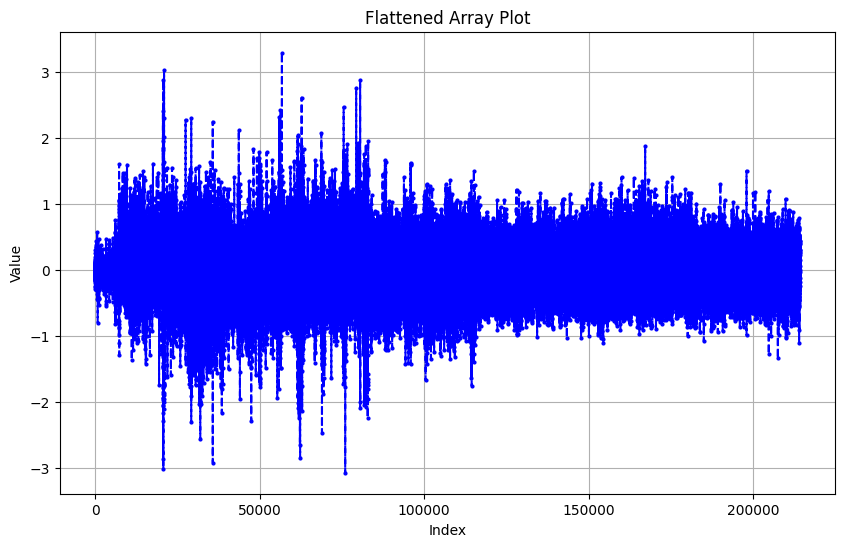

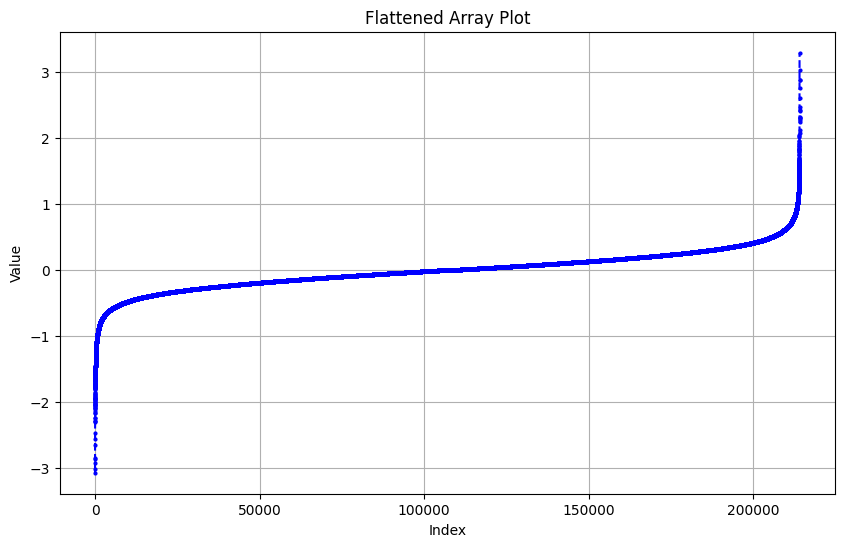

In [43]:
plot_flattened_params(params_array)
plot_flattened_params(np.sort(params_array))

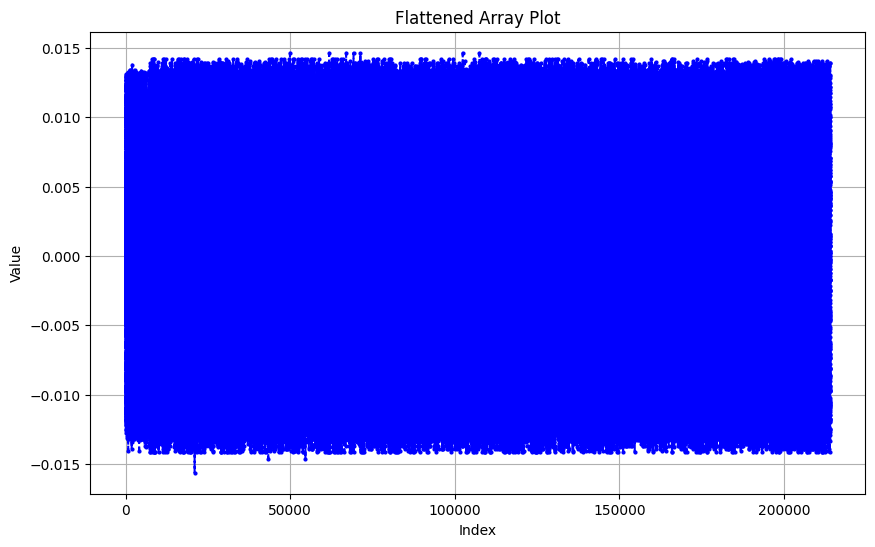

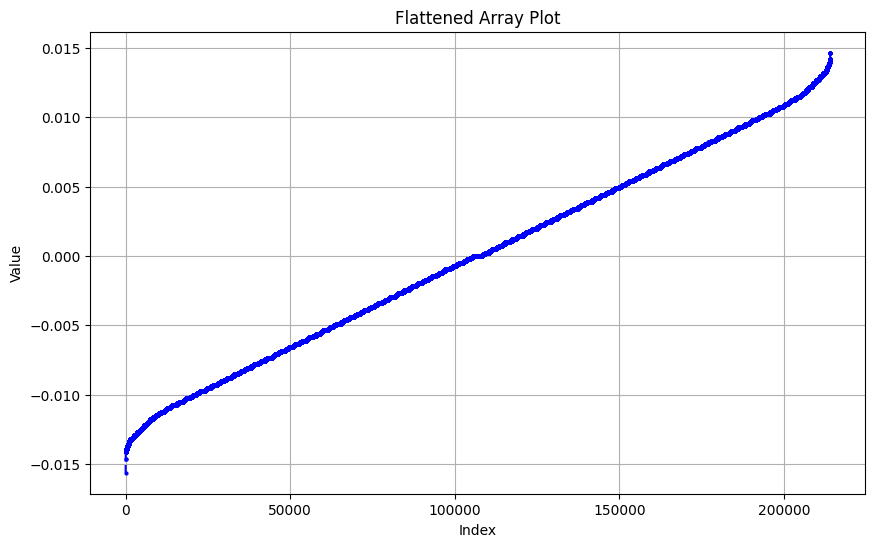

In [46]:
error = (params_np_half - half_dq)
plot_flattened_params(error)
plot_flattened_params(np.sort(error))

In [86]:
# load rendered images of quantized snapshots
import glob

original_image_path = "/Users/nasib/code/instant-ngp/data/image/KODAK/kodim11.png"

path_to_images = "/Users/nasib/code/instant-ngp/data"
images = glob.glob(path_to_images + '/*.png')
images.sort()
images

['/Users/nasib/code/instant-ngp/data/10bit_image.png',
 '/Users/nasib/code/instant-ngp/data/11bit_image.png',
 '/Users/nasib/code/instant-ngp/data/12bit_image.png',
 '/Users/nasib/code/instant-ngp/data/13bit_image.png',
 '/Users/nasib/code/instant-ngp/data/14bit_image.png',
 '/Users/nasib/code/instant-ngp/data/15bit_image.png',
 '/Users/nasib/code/instant-ngp/data/16bit_image.png',
 '/Users/nasib/code/instant-ngp/data/1bit_image.png',
 '/Users/nasib/code/instant-ngp/data/2bit_image.png',
 '/Users/nasib/code/instant-ngp/data/3bit_image.png',
 '/Users/nasib/code/instant-ngp/data/4bit_image.png',
 '/Users/nasib/code/instant-ngp/data/5bit_image.png',
 '/Users/nasib/code/instant-ngp/data/6bit_image.png',
 '/Users/nasib/code/instant-ngp/data/7bit_image.png',
 '/Users/nasib/code/instant-ngp/data/8bit_image.png',
 '/Users/nasib/code/instant-ngp/data/9bit_image.png']

In [109]:
import re
from PIL import Image
import numpy as np

og_image = Image.open(original_image_path)
og_image_array = np.array(og_image, dtype=np.float32) / 255.0

# Initialize results array
results = np.zeros((len(images), 7))

header = ["nr_bits", "L2", "MSE", "PSNR", "min_diff", "max_diff", "SSIM"]

# Regular expression pattern to match numbers
pattern = r"\d+"

for ind, image_path in enumerate(images):
    match = re.findall(pattern, image_path)
    if match and len(match) == 1:
        nr_bits = int(match[0])
    else:
        raise RuntimeError(f"Ambiguous or no nr of bits specified in {image_path}")

    # Open the PNG image using PIL
    image = Image.open(image_path)

    # Convert the PIL image to a NumPy array
    image_array = np.array(image, dtype=np.float32) / 255.0

    # Compute difference between original and rendered image
    difference = np.abs(og_image_array - image_array)

    # Store the number of bits used for quantization
    results[ind, 0] = nr_bits

    # Compute L2 distance between original and rendered image
    results[ind, 1] = np.linalg.norm(difference)

    # Compute MSE between original and rendered image
    results[ind, 2] = np.mean((difference) ** 2)

    # Compute PSNR between original and rendered image
    results[ind, 3] = 10 * np.log10(255**2 / results[ind, 1])

    # Min difference
    results[ind, 4] = difference.min()

    # Max difference
    results[ind, 5] = difference.max()

    # Compute SSIM between original and rendered image
    # results[ind, 4] = (ssim(image_array, og_image_array, multichannel=True))
    # results[ind, 4] = float(compute_error("SSIM", A, R))

    # Convert the NumPy array to a PIL image
    diff_image = Image.fromarray((difference * 255.0).astype(np.uint8))

    # Save the PIL image as a PNG file
    diff_image.save(
        f"""/Users/nasib/code/instant-ngp/data/quant_exp_data/{bit_list[ind]}bit_diff_image.png"""
    )

# save results
np.savetxt("/Users/nasib/code/instant-ngp/data/quant_exp_data/results.csv", results, delimiter=',', header=",".join(header))

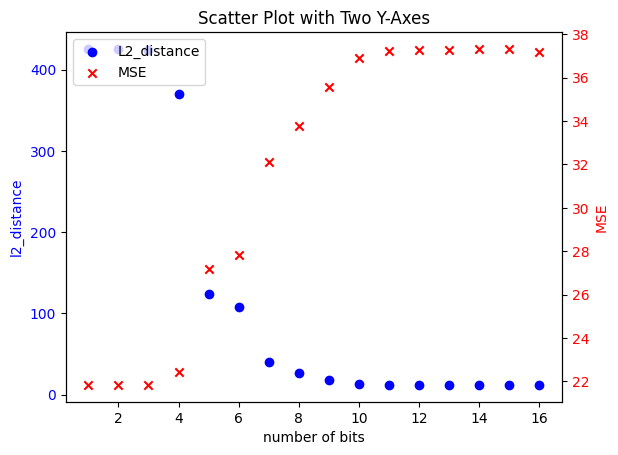

In [117]:
import numpy as np
import matplotlib.pyplot as plt

# Create a scatter plot for the first y-axis
fig, ax1 = plt.subplots()

x = results[:, 0]  # nr_bits

ax1.scatter(x, results[:, 1], label='L2_distance', color='blue', marker='o')
ax1.set_xlabel('number of bits')
ax1.set_ylabel('l2_distance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a scatter plot for the second y-axis on the right
ax2 = ax1.twinx()

ax2.scatter(x, results[:, 3], label='MSE', color='red', marker='x')
ax2.set_ylabel('MSE', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a legend for both datasets
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Title for the plot
plt.title('Scatter Plot with Two Y-Axes')

# Display the plot (if using Jupyter Notebook, this step may not be necessary)
plt.show()

[[[-0.01176471 -0.00392157  0.00392157]
  [ 0.          0.00392157  0.        ]
  [ 0.00784314  0.         -0.01176471]
  ...
  [ 0.00392157  0.00392157  0.00392157]
  [ 0.          0.00392157  0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.00392157  0.          0.00392157]
  [ 0.00392157 -0.00392157 -0.00392157]
  [-0.00392157 -0.00784314 -0.00392157]
  ...
  [ 0.01176471  0.01176471  0.01176471]
  [ 0.00392157  0.00392157  0.00392157]
  [ 0.00392157  0.00392157  0.00392157]]

 [[ 0.00784314  0.          0.        ]
  [ 0.01176471  0.00784314  0.00392157]
  [ 0.00784314  0.00392157  0.00392157]
  ...
  [ 0.01176471  0.01176471  0.00784314]
  [ 0.01568627  0.01568627  0.01176471]
  [ 0.00784314  0.00784314  0.00784314]]

 ...

 [[ 0.          0.01176471  0.01568627]
  [-0.00392157 -0.01176471 -0.01176471]
  [ 0.02352941  0.00392157  0.00784314]
  ...
  [ 0.         -0.02352941 -0.01568627]
  [ 0.00392157 -0.00784314 -0.00392157]
  [ 0.          0.00392157  0.00392157]]

 [